
Convolutional Neural networks (CNNs) have been found to be very effective at 
tasks such as facial recognition, video analysis, anomaly detections and semantic 
parsing. An image can be considered a graph with a very regular structure (i.e., 
pixels are considered nodes, with edges connecting adjacent nodes). A natural 
idea is to extend convolutions to general graphs for tasks such as graph, node 
or edge classification. However, it is not immediately clear how one would go 
about extending the concept of convolutions in the context of CNNs to graphs. 


In the Kipf and Welling paper, 
[*Semi-Supervised Classification with Graph Convolutional Networks*](https://arxiv.org/pdf/1609.02907.pdf), 
the authors propose a method to approximate the spectral graph convolution via truncated 
Chebyshev polynomials, resulting in an efficient and scalable method to train graph 
neural networks. In this post, we walkthrough the graph convolutional network (GCN) 
propagation model, which we also implement in pytorch geometric. Thomas Kipf's original 
PyTorch implementation is available [here](https://github.com/tkipf/gcn).


### GCN Propagation Model

The GCN forward pass is presented as:

$$
H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})
$$

Where:
- $\boldsymbol{n}$:  number of nodes in graph  
- $\boldsymbol{c}$:  length of feature vector for each node   
- $\boldsymbol{f}$:  size of projection layer  
- $\boldsymbol{A}$:  n-by-n adjacency matrix  
- $\boldsymbol{\tilde{A}}$:  n-by-n adjacency matrix with added self-connections  
- $\boldsymbol{\tilde{D}}$:  n-by-n degree matrix of $\boldsymbol{\tilde{A}}$  
- $\boldsymbol{H^{(l+1)}}$:  n-by-c matrix of feature vectors for all nodes  
- $\boldsymbol{W^{(l)}}$:  c-by-f linear projection layer    
- $\boldsymbol{\sigma}$: non-linearity, such as ReLU  


This becomes clear with an example. We create an undirected graph with 5 nodes:



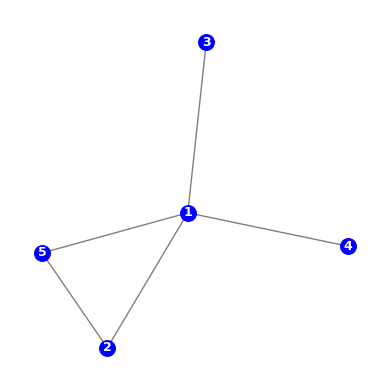

In [1]:
# | fig-cap: 5-node, 5-edge undirected graph
# | fig-alt: An undirected graph with 5 blue numbered nodes with 5 edges
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

edges = [
    (1, 2), (1, 3), (1, 4), (1, 5), (2, 5)
    ]

G.add_edges_from(edges)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
pos = nx.spring_layout(G, seed=508)
nx.draw_networkx_nodes(G, pos, node_size=125, node_color="blue")
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1, alpha=0.5, edge_color="black", style="solid")
nx.draw_networkx_labels(G, pos, font_size=9, font_color="white", font_weight="bold", font_family="sans-serif")
plt.axis("off")
plt.show();



The elements of the adjacency matrix indicate whether pairs of vertices are 
connected in the graph. For the graph shown above, the adjacency matrix is given 
by:

$$
\boldsymbol{A} = 
\begin{pmatrix}
0 & 1 & 1 & 1 & 1 \\
1 & 0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 & 0
\end{pmatrix}
$$

The first row indicates the nodes adjacent to node 1. Since node 1 is connected 
to all other nodes, all but the first cell are set to 1 (no self connections in $A$). 

$\tilde{A} = A + I$, where $I$ is the length-n identity matrix. This has the 
effect of adding self-connections to each node. We have:

$$
\boldsymbol{\tilde{A}} = 
\begin{pmatrix}
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 0 & 0 & 1 \\
1 & 0 & 1 & 0 & 0 \\
1 & 0 & 0 & 1 & 0 \\
1 & 1 & 0 & 0 & 1
\end{pmatrix}
$$

After adding self-connections, the graph becomes:

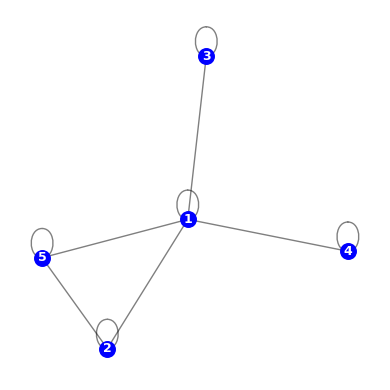

In [2]:
# | fig-cap: 5-node graph with added self-connections
# | fig-alt: An undirected graph with 5 blue numbered nodes with added self-connections

G = nx.Graph()

edges = [
    (1, 2), (1, 3), (1, 4), (1, 5), (2, 5),
    (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)
    ]

G.add_edges_from(edges)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
pos = nx.spring_layout(G, seed=508)
nx.draw_networkx_nodes(G, pos, node_size=125, node_color="blue")
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1, alpha=0.5, edge_color="black", style="solid")
nx.draw_networkx_labels(G, pos, font_size=9, font_color="white", font_weight="bold", font_family="sans-serif")
plt.axis("off")
plt.show()



$\tilde{D}$ is a diagonal matrix, containing the row-wise sum of $\tilde{A}$ for 
each entry:

$$
\boldsymbol{\tilde{D}} = 
\begin{pmatrix}
5 & 0 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 & 0 \\
0 & 0 & 2 & 0 & 0 \\
0 & 0 & 0 & 2 & 0 \\
0 & 0 & 0 & 0 & 3
\end{pmatrix}
$$

To get to $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$, each 
element of $\tilde{A}$ is divided by $1 / \sqrt{d_{i} d_{j}}$ for entries in 
$\tilde{D}$. This normalization ensures the largest eigenvalue = 1, and addresses 
the issue of exploding/vanishing gradients during training:

$$
\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} = 
\begin{pmatrix}
\frac{1}{\sqrt{{5}\cdot{5}}} & \frac{1}{\sqrt{{5}\cdot{2}}} & \frac{1}{\sqrt{{5}\cdot{2}}} & \frac{1}{\sqrt{{5}\cdot{2}}} & \frac{1}{\sqrt{{5}\cdot{3}}} \\
\frac{1}{\sqrt{{2}\cdot{5}}} & \frac{1}{\sqrt{{2}\cdot{2}}} & 0 & 0 & 0 \\
\frac{1}{\sqrt{{2}\cdot{5}}} & 0 & \frac{1}{\sqrt{{2}\cdot{2}}} & 0 & 0 \\
\frac{1}{\sqrt{{2}\cdot{5}}} & 0 & 0 & \frac{1}{\sqrt{{2}\cdot{2}}} & 0 \\
\frac{1}{\sqrt{{3}\cdot{5}}} & \frac{1}{\sqrt{{3}\cdot{2}}} & 0 & 0 & \frac{1}{\sqrt{{3}\cdot{3}}} \\
\end{pmatrix}
$$


Note that during training, $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$ 
is only computed once since the values will not change.

Each node has an associated feature vector of length $c$.  $H^{(l)}$ represents 
stacked feature vectors for all nodes, resulting in a matrix of dimension n-by-c. 
$H^{(0)} = X$, the original features.

$W^{(l)}$ is the linear projection layer, which reduces the representation of each 
node from length c to length f. If we assume f = 64, $H^{(l+1)}$ becomes:

$$
H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}) \rightarrow \mathrm{ReLU}(n \times 64)
$$

For a 2-layer GCN, the full propagation model for a node classification task is:

$$
\begin{align*}
\hat{A} &= \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}\\
Z &= \mathrm{softmax}\big(\hat{A} \hspace{.30em}\mathrm{ReLU}(\hat{A}XW^{(0)}) \hspace{.30em} W^{(1)} \big)
\end{align*}
$$



## Derivation of Propagation Model

The authors begin with an expression to perform spectral convolutions on graphs:

$$
g_{\theta} \star x = U g_{\theta} U^{T} x,
$$

where $U$ is the matrix of eigenvectors of the normalized Laplacian 
$L = I_{n} - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$, and $U^{T}x$ represents the 
graph Fourier transform of $x$. However, this as expensive operation, since the 
spectral decomposition is $\mathcal{O}(n^{3})$ in practice. In addition, it isn't 
immediately clear how one would go about incorporating this operation within the 
context of forward/back-propagation. 

Citing a paper by [Hammond et. al](https://arxiv.org/pdf/0912.3848.pdf), they 
propose an approximation to $g_{\theta} \star x$ via a truncated expansion in terms 
of Chebyshev polynomials $T_{k}(x)$ up to $K^{th}$ order:

$$
g_{\theta} \star x \approx \sum_{k=0}^{K} \theta^{'}_{k} T_{k}(\tilde{L})x \hspace{.75em}(*),
$$

where $\tilde{L} = \frac{2}{\lambda_{\mathrm{max}}}L - I_{N}$ and $\theta^{'}$ is a 
vector of Chebyshev coefficients. Note that for the Chebyshev polynomial expansion, 
$T_{0}(x) = 1$, $T_{1}(x) = x$ and all other terms are recursively defined as 
$T_{k}(x) = 2xT_{k-1}(x) - T_{k-2}(x)$.

By leveraging ${(*)}$ to approximate graph convolutions, the runtime complexity 
becomes linear in terms of the number of edges ($\mathcal{O}(|\mathcal{E}|)$ 
instead of cubic in the number of nodes as is the case for the full spectral graph 
convolution. 

From this point, the authors make three simplifications/assumptions which result 
in the propagation model introduced earlier:

$$
H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}).
$$

The first two simplifications are $K=1$ and $\lambda_{\mathrm{max}} = 2$. 
Expanding $({*})$ with $K=1$ and $\lambda_{\mathrm{max}} = 2$ results in:

$$
g_{\theta} \star x \approx \theta^{'}_{0}x + \theta^{'}_{1}(L - I_{N})x = \theta^{'}_{0}x - \theta^{'}_{1}D^{-\frac{1}{2}}AD^{-\frac{1}{2}}x
$$

The third simplification sets $\theta = \theta^{'}_{0} = -\theta^{'}_{1}$. This 
constrains the number of parameters to address overfitting and to minimize the 
number of multiplications per layer. Doing so results in:

$$
g_{\theta} \star x \approx \theta \big(I_{N} + D^{-\frac{1}{2}}AD^{-\frac{1}{2}} \big)x.
$$

To address the issue of exploding/vanishing gradients during training they apply 
a renormalization trick, essentially swapping $A$ and $D$ with 
$\tilde{A}$ and $\tilde{D}$. This ensures eigenvalues are the the range [-1, 1]. 
We can show this is the case for our example using the adjacency matrix associated
with our 5 node graph:

In [3]:

import numpy as np
import networkx as nx

np.set_printoptions(suppress=True, precision=5)


G = nx.Graph()
edges = [(1, 2), (1, 3), (1, 4), (1, 5), (2, 5)]

G.add_edges_from(edges)
A = nx.adjacency_matrix(G).todense()
I = np.identity(5)
D = np.diag(np.sum(A, axis=1))

# Check range of eigenvalues without renormalization.
Dp = np.linalg.inv(np.power(D, .5))
evals0, _ = np.linalg.eig(I + Dp @ A @ Dp)

# Check range of eigenvalues after renormalization trick. 
Atilde = A + I
Dtilde = np.diag(np.sum(Atilde, axis=1))
Dtildep = np.linalg.inv(np.power(Dtilde, .5))
evals1, _ = np.linalg.eig(Dtildep @ Atilde @ Dtildep)

print(f"\neigenvalues without renormalization: {evals0}")
print(f"eigenvalues with renormalization   : {evals1}")


eigenvalues without renormalization: [0.19098 2.      1.30902 0.5     1.     ]
eigenvalues with renormalization   : [-0.22526  1.       0.59192  0.5      0.     ]



By replacing $\big(I_{N} + D^{-\frac{1}{2}}AD^{-\frac{1}{2}} \big)$ 
with $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$, we end up with:

$$
Z = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}X\Theta,
$$

where $\Theta$ is a c-by-f matrix of filter parameters and $Z$ is the n-by-f 
convolved signal matrix.    
The final propagation model has nothing to do with the spectral decomposition: 
No eigenvectors/eigenvalues are actually computed. The approach was motivated by 
spectral convolutions on graphs, but is not a spectral method itself.



### PyTorch Geometric GCN Implementation
In what follows, we demonstrate how to set up a 2-layer GCN for node classification 
using PyTorch Geometric and the Cora citation network.


In [4]:

import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = Planetoid(root='/tmp/Cora', name='Cora')
split = T.RandomNodeSplit(num_val=0.15, num_test=0.10)
graph = split(dataset[0])



### Distribution of classes in Cora

The Cora dataset is a citation network, where each node represents a paper belonging 
to one of the following 7 classes. Our goal is to predict the labels assigned to 
each node in the network:


In [5]:

dclasses = {
    0: "Theory",
    1: "Reinforcement_Learning", 
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
    }

df = (
    pd.DataFrame(graph.y.tolist()) 
    .groupby(0, as_index=False).size()
    .rename({0: "id", "size": "n"}, axis=1)
    )

df["desc"] = df["id"].map(dclasses)
df["prop"] = df["n"] / df["n"].sum()
df[["id", "desc", "n", "prop"]].head(7)


,id,desc,n,prop
0,0,Theory,351,0.129616
1,1,Reinforcement_Learning,217,0.080133
2,2,Genetic_Algorithms,418,0.154357
3,3,Neural_Networks,818,0.302068
4,4,Probabilistic_Methods,426,0.157312
5,5,Case_Based,298,0.110044
6,6,Rule_Learning,180,0.066470



### GCN Model

Next we implement GCN using PyTorch Geometric. The original PyTorch implementation 
is available [here](https://github.com/tkipf/pygcn).



In [6]:

import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)
        return(output)


def train_classifier(model, graph, optimizer, criterion, n_epochs=100):
    """
    Training loop.
    """
    tm, vm = graph.train_mask, graph.val_mask
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(graph)
        loss = criterion(output[tm], graph.y[tm])
        loss.backward()
        optimizer.step()

        # Validate. 
        model.eval()
        pred = model(graph).argmax(dim=1)
        correct = (pred[vm] == graph.y[vm]).sum()
        acc = correct / vm.sum()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: train loss={loss:.3f}, val. acc={acc:.3f}.")

    return(model)


Training our network:


In [7]:

# Capture activations from last hidden layer to re-create plot
# from paper.
activations = {}
def get_activation(name):
    def hook(gcn, input, output):
        activations[name] = output.detach()
    return(hook)

# Put graph on GPU if available.
graph = graph.to(device)
gcn = GCN(num_features=1433, num_classes=7).to(device)
gcn.conv2.register_forward_hook(get_activation("conv2"))
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_classifier(gcn, graph, optimizer, criterion)

# Compute test accuracy.
gcn.eval()
pred = gcn(graph).argmax(dim=1)
correct = (pred[graph.test_mask] == graph.y[graph.test_mask]).sum()
test_acc = correct / graph.test_mask.sum()
print(f"\nTest accuracy: {test_acc:.3f}\n")


Epoch 0: train loss=1.932, val. acc=0.303.
Epoch 10: train loss=0.377, val. acc=0.862.
Epoch 20: train loss=0.181, val. acc=0.867.
Epoch 30: train loss=0.119, val. acc=0.857.
Epoch 40: train loss=0.088, val. acc=0.852.
Epoch 50: train loss=0.069, val. acc=0.845.
Epoch 60: train loss=0.058, val. acc=0.847.
Epoch 70: train loss=0.050, val. acc=0.850.
Epoch 80: train loss=0.044, val. acc=0.855.
Epoch 90: train loss=0.040, val. acc=0.855.

Test accuracy: 0.893





### Display hidden layer activations with t-SNE

Finally, we can display a lower dimensional representation of the final hidden 
layer node embeddings using t-SNE. The resulting plot looks similar to figure 1b 
from the original paper, but experimenting with the t-SNE perplexity parameter 
will probably get you even closer:


Xemb.shape: (2708, 2)


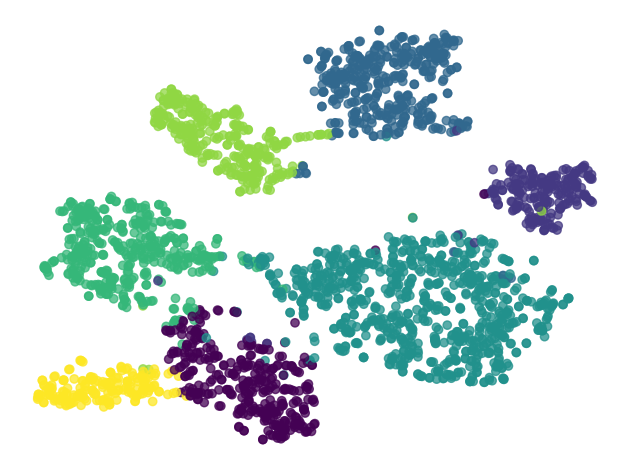

In [11]:
# | fig-cap: Lower dimensional representation of the final hidden layer using t-SNE
# | fig-alt: Lower dimensional representation of the final hidden layer using t-SNE

from sklearn.manifold import TSNE

X = activations["conv2"].cpu().numpy()
Xemb = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X)
print(f"Xemb.shape: {Xemb.shape}")

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.scatter(Xemb[:,0], Xemb[:,1], c=pred.cpu(), alpha=.75)
ax.axis("off")
plt.show();
